# Comparing NNLS solvers

I'll compare the fortran and python implementations for accuracy and speed.

I've already orbit libraries for 19 models, let's load these the config

In [3]:
import matplotlib.pyplot as plt

import dynamite as dyn
print('Using DYNAMITE version:', dyn.__version__)
print('Located at:', dyn.__path__)

# read configuration
fname = 'test_reimplement_nnls.yaml'
c = dyn.config_reader.Configuration(fname, silent=True)

Using DYNAMITE version: 0.0.0
Located at: ['/Users/pjethwa/miniconda3/envs/dyn_env/lib/python3.6/site-packages/dynamite-0.0.0-py3.6.egg/dynamite']
Previous models have been found:
Reading NGC6278_output/all_models.ecsv into AllModels.table


In [4]:
import numpy as np
ngh = 4
k = np.arange(ngh) * 3 + 3

print(k)

[ 3  6  9 12]


Write come helper wrapper functions to solve for orbital weights in Fortran and Python.

These do a number of things, (i) unzip the orbit libraries to file, (ii) read orbit libraries + intrinsic/projected masses, (iii) calculate GH coefficients, (iii) construct the NNLS matrix and constraint vector, (iv) optionally apply 'CRcut', (v) solve. This is all wrapped up in `triaxnnls_CRcut`. For fairness, in python implementation I do all of this also. Timing comparisons refer to this whole procedure.


Define some helper wrapper functions,

In [5]:
import os

def reset_fortran_output(mod_idx):
    parset0 = c.all_models.get_parset_from_row(mod_idx)
    mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                              settings=c.settings,
                                              parspace=c.parspace,
                                              parset=parset0)
    direc0 = mod0.get_model_directory()
    files = os.listdir(direc0)
    for f in files:
        os.remove(f'{direc0}{f}')
    return

def solve_with_fortran(mod_idx, CRcut=False):
    reset_fortran_output(mod_idx)
    parset0 = c.all_models.get_parset_from_row(mod_idx)
    mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                              settings=c.settings,
                                              parspace=c.parspace,
                                              parset=parset0)
    weight_solver = dyn.weight_solvers.LegacyWeightSolver(
        system=c.system,
        settings=c.settings.weight_solver_settings,
        mod_dir=mod0.directory_noml,
        legacy_directory=c.settings.legacy_settings['directory'],
        CRcut=CRcut,
        ml=parset0['ml'])
    chi2, kinchi2 = weight_solver.solve(None)
    weight_solver.read_weights()
    weights = weight_solver.weights['weight'].data
    return weights, chi2

def solve_with_python(mod_idx, CRcut=False):
    parset0 = c.all_models.get_parset_from_row(mod_idx)
    mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                              settings=c.settings,
                                              parspace=c.parspace,
                                              parset=parset0)
    orblib0 = mod0.get_orblib()
    new_weight_solver = dyn.weight_solvers.PrashsCoolNewWeightSolver(
        system=c.system,
        settings=c.settings.weight_solver_settings,
        directory_noml=mod0.directory_noml,
        CRcut=CRcut)
    weights, chi2 = new_weight_solver.solve(orblib0)
    # = chi2 of hermite coefficients, only
    return weights, chi2

In [6]:
mod_idx = 0

parset0 = c.all_models.get_parset_from_row(mod_idx)
mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                          settings=c.settings,
                                          parspace=c.parspace,
                                          parset=parset0)
orblib0 = mod0.get_orblib()

reset_fortran_output(mod_idx)
weight_solver = dyn.weight_solvers.LegacyWeightSolver(
    system=c.system,
    settings=c.settings.weight_solver_settings,
    mod_dir=mod0.directory_noml,
    legacy_directory=c.settings.legacy_settings['directory'],
    CRcut=True,
    ml=parset0['ml'])
chi2, kinchi2 = weight_solver.solve(None)
weight_solver.read_weights()
orbmat_f_crc, _, _ = weight_solver.read_nnls_orbmat_rhs_and_solution()

reset_fortran_output(mod_idx)
weight_solver = dyn.weight_solvers.LegacyWeightSolver(
    system=c.system,
    settings=c.settings.weight_solver_settings,
    mod_dir=mod0.directory_noml,
    legacy_directory=c.settings.legacy_settings['directory'],
    CRcut=False,
    ml=parset0['ml'])
chi2, kinchi2 = weight_solver.solve(None)
weight_solver.read_weights()
orbmat_f_ncrc, _, _ = weight_solver.read_nnls_orbmat_rhs_and_solution()


Fit the orbit library to the kinematic data.
NNLS problem solved
Fit the orbit library to the kinematic data.
NNLS problem solved


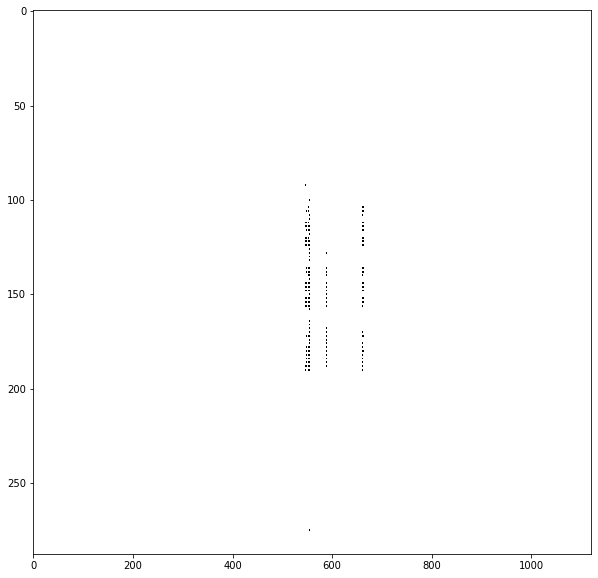

In [7]:
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(np.isclose(orbmat_f_crc, orbmat_f_ncrc), aspect='auto', interpolation='none', cmap=plt.cm.Greys_r)

In [20]:
mge = c.system.cmp_list[2].mge

mge.get_intrinsic_masses_from_file(mod0.directory_noml)

array([[[0.00041553, 0.00041552, 0.0004155 , 0.00041548, 0.00041547,
         0.00041546, 0.0012555 , 0.00125536, 0.00125512, 0.00125484],
        [0.0012546 , 0.00125447, 0.00210663, 0.00210606, 0.00210507,
         0.00210394, 0.00210295, 0.00210239, 0.00292538, 0.00292402],
        [0.00292167, 0.00291895, 0.0029166 , 0.00291525, 0.00360535,
         0.00360303, 0.00359901, 0.00359438, 0.00359038, 0.00358807],
        [0.00400064, 0.00399763, 0.00399242, 0.00398643, 0.00398124,
         0.00397826, 0.00011832, 0.00011832, 0.00011832, 0.00011831],
        [0.0001183 , 0.0001183 , 0.00036099, 0.00036094, 0.00036085,
         0.00036075, 0.00036067, 0.00036062, 0.00061819, 0.00061796],
        [0.00061758, 0.00061713, 0.00061675, 0.00061653, 0.00088456,
         0.00088397, 0.00088294, 0.00088176, 0.00088074, 0.00088015]],

       [[0.00112579, 0.00112467, 0.00112274, 0.00112052, 0.0011186 ,
         0.00111749, 0.00127626, 0.00127473, 0.00127207, 0.00126902],
        [0.00126639, 0.00

In [8]:
mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                          settings=c.settings,
                                          parspace=c.parspace,
                                          parset=parset0)
new_weight_solver = dyn.weight_solvers.PrashsCoolNewWeightSolver(
    system=c.system,
    settings=c.settings.weight_solver_settings,
    directory_noml=mod0.directory_noml,
    CRcut=True)
orbmat_p_crc, _ = new_weight_solver.construct_nnls_matrix_and_rhs(orblib0)


new_weight_solver = dyn.weight_solvers.PrashsCoolNewWeightSolver(
    system=c.system,
    settings=c.settings.weight_solver_settings,
    directory_noml=mod0.directory_noml,
    CRcut=False)
orbmat_p_ncrc, _ = new_weight_solver.construct_nnls_matrix_and_rhs(orblib0)


/Users/pjethwa/miniconda3/envs/dyn_env/lib/python3.6/site-packages/dynamite-0.0.0-py3.6.egg/dynamite/kinematics.py:454: RuntimeWarning: invalid value encountered in true_divide
  mean /= norm


In [12]:
mod0.get_model_directory()

'NGC6278_output/models/mass_black_hole1e+05a_black_hole0.001dc_dark_halo12f_dark_halo10q_stars0.54p_stars0.99u_stars0.9999/ml5.00/'

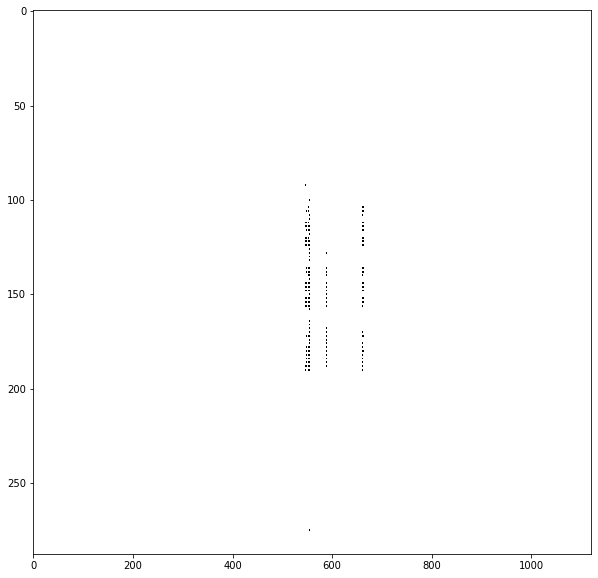

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(np.isclose(orbmat_p_crc.T, orbmat_p_ncrc.T),
          aspect='auto',
          interpolation='none',
          cmap=plt.cm.Greys_r)

In [10]:
np.allclose(orbmat_f_ncrc, orbmat_p_ncrc.T)

True

In [11]:
np.allclose(orbmat_f_crc, orbmat_p_crc.T)

False

NameError: name 'orbmat_f' is not defined

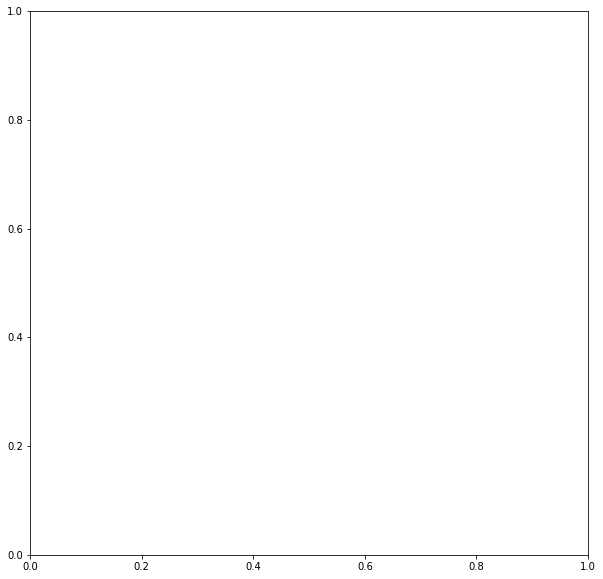

In [11]:
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10,10))
is_close = np.isclose(orbmat_f, orbmat_p.T, rtol=1e-10, atol=1e-10)
cm = ax.imshow(is_close,
          aspect='auto', interpolation='none', cmap=plt.cm.Greys_r)
ax.axhline(size, c='r', alpha=0.2)
ax.axhline(2*size, c='r', alpha=0.2)
ax.axvline(361, c='r', alpha=0.2)
ax.axvline(361+152, c='r', alpha=0.2)
for i in range(4):
    ax.axvline(361+152*(i+1), ls=':', c='r', alpha=0.2)
ax.set_title('White <--> Equal ... Black <--> Not-Equal')
ax.set_xlabel('constraint')
ax.set_ylabel('orbit')
plt.show()

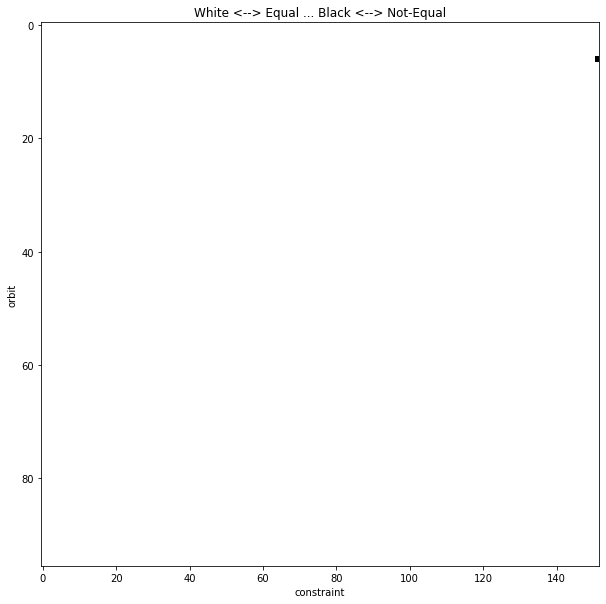

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
cm = ax.imshow(is_close[size:2*size, 361+152:361+2*152],
          aspect='auto', interpolation='none', cmap=plt.cm.Greys_r)
ax.set_title('White <--> Equal ... Black <--> Not-Equal')
ax.set_xlabel('constraint')
ax.set_ylabel('orbit')
plt.show()

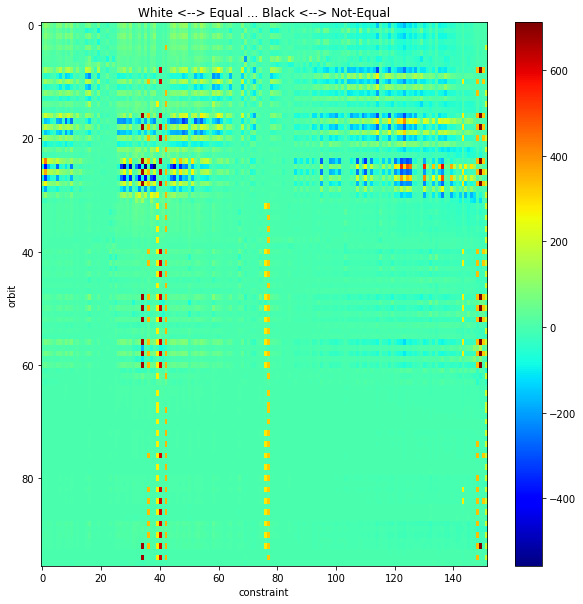

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
cm = ax.imshow(orbmat_f[size:2*size, 361+152:361+2*152],
          aspect='auto', interpolation='none', cmap=plt.cm.jet)
ax.set_title('White <--> Equal ... Black <--> Not-Equal')
ax.set_xlabel('constraint')
ax.set_ylabel('orbit')
fig.colorbar(cm)
plt.show()

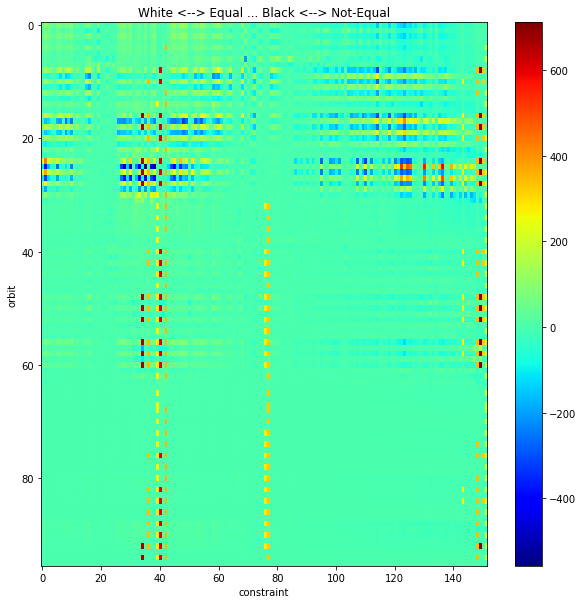

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
cm = ax.imshow(orbmat_p.T[size:2*size, 361+152:361+2*152],
          aspect='auto', interpolation='none', cmap=plt.cm.jet)
ax.set_title('White <--> Equal ... Black <--> Not-Equal')
ax.set_xlabel('constraint')
ax.set_ylabel('orbit')
fig.colorbar(cm)
plt.show()

Most of the differences come from the ``h1`` of reversed tube orbits. This feels uncomfortably like something to do with CR cut.






## Basic timing comparison

In [ ]:
%time w_for, chi2_for = solve_with_fortran(0, CRcut=False)

In [ ]:
%time w_py, chi2_py = solve_with_python(0, CRcut=False)

## Compare weights

In [ ]:
def compare_python_fortran(mod_idx, CRcut=False):
    print(f'Model {mod_idx}')
    print('Solving in Fortran')
    w_for, chi2_for = solve_with_fortran(0, CRcut=CRcut)
    print('Solving in Python')
    w_py, chi2_py = solve_with_python(0, CRcut=CRcut)
    print('Chi2 values:')
    print(f'     ... fortran: {chi2_for}')
    print(f'     ... python: {chi2_py}')
    fig, ax = plt.subplots(2, 1, figsize=(14,5), sharex=True)
    ax[0].plot(w_for, label='fortran')
    ax[0].plot(w_py, ':', label='python')
    ax[1].plot(w_py-w_for, '-')
    ax[1].set_xlabel('orbit')
    ax[0].set_ylabel('weight')
    ax[1].set_ylabel('$w_{py} - w_{for}$')
    ax[0].legend()
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)

In [ ]:
compare_python_fortran(0)

A good match - but not perfect. Why not perfect?

Possibly due to some difference in implementing CRcut. All Fortran results do include `CRcut`. I optionally can turn this on/off in python implementatiom. The comparison, when I turn this off, looks worse,


In [ ]:
compare_python_fortran(0, CRcut=True)

Notice the factor 10 increasse in the size of residuals.

So `CRcut` does affect the results. So, why, when I *do* include it, do the comparisons not match perfectly? I still think it is some difference in how CRcut is implemented. Very different implementations, hard to pin down exactly.

So, we can't expect identical results. TO-DO: comparison with CRcut turned off in fortran.

## Compare Chi2 values

Now let's compare solutions over a grid of models. I have 18 orbit libraries calculated, lets calculte chi2 for each. First in Fortran

In [ ]:
%time chi2_list_for = [solve_with_fortran(i)[1] for i in range(19)]

In [ ]:
%time chi2_list_py = [solve_with_python(i)[1] for i in range(19)]

In [ ]:
def plot_chi_vals(chi2_vals, vmin=None, vmax=None):
    allmods = c.all_models.table
    plt.scatter(allmods['f_dark_halo'],
                allmods['ml'],
                vmax=vmax,
                vmin=vmin,
                s=100,
                c=chi2_vals)
    plt.colorbar()
    plt.gca().set_xscale('log')
    plt.gca().set_ylabel('ml')
    plt.gca().set_xlabel('$f_{DM}(<R_{200})$')

In [ ]:
plot_chi_vals(chi2_list_for, vmin=2600, vmax=4000)

In [ ]:
plot_chi_vals(chi2_list_py, vmin=2600, vmax=4000)

And plotting the fractional difference,

In [ ]:
import numpy as np
chi2_list_py = np.array(chi2_list_py)
chi2_list_for = np.array(chi2_list_for)
delta_chi2 = (chi2_list_py-chi2_list_for)/chi2_list_for
plot_chi_vals(delta_chi2)

Differences of up to 10%. Not ideal! This could be down to
- CR cut - will need to turn this off in the Fortran implementation to check
- a different definiton of chi2. I think these two are comparible (just hermite coefficients), but there are several different chi2's used in fortran, and it's possible that the value shown here is not what I think it is

# compare timings at different size orblibs

In [ ]:
import time

def time_nnls_solvers_vs_orblib_size(nE, nI2, nI3):
    # set things up
    outdir = f'nnls_time_vs_orblib_size/{nE}_{nI2}_{nI3}/'
    c.settings.io_settings['output_directory'] = outdir
    if os.path.isdir(outdir) is False:
        os.mkdir(outdir)
    c.settings.orblib_settings['nE'] = nE
    c.settings.orblib_settings['I2'] = nI2
    c.settings.orblib_settings['I3'] = nI3
    parset0 = c.all_models.get_parset_from_row(0)
    mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                              settings=c.settings,
                                              parspace=c.parspace,
                                              parset=parset0)
    mod0.setup_directories()
    orblib0 = mod0.get_orblib()
    # reset_fortran_output
    direc0 = mod0.get_model_directory()
    files = os.listdir(direc0)
    for f in files:
        os.remove(f'{direc0}{f}')
    # solve with fortran
    t_start = time.time()
    ws0 = mod0.get_weights(None)
    weights = ws0.weights['weight'].data
    chi2 = mod0.chi2      # = chi2 of hermite coefficients only
    t_end = time.time()
    duration = t_end - t_start
    result_for = {'weights':weights, 'chi2':chi2, 'duration':duration}
    # solve with python
    t_start = time.time()
    orblib0.read_losvd_histograms()
    new_weight_solver = dyn.weight_solvers.PrashsCoolNewWeightSolver(
        system=c.system,
        settings=c.settings.weight_solver_settings,
        directory_noml=mod0.directory_noml,
        CRcut=True)
    weights, chi2 = new_weight_solver.solve(orblib0)
    t_end = time.time()
    duration = t_end - t_start
    result_py = {'weights':weights, 'chi2':chi2, 'duration':duration}
    size = nE*nI2*nI3
    return size, result_for, result_py

In [ ]:
result = []
for (nE, nI2, nI3) in [(4,4,4), (8,8,4), (16,8,8), (16,16,16), (32,32,16)]:
    result += [time_nnls_solvers_vs_orblib_size(nE, nI2, nI3)]

Compare the weights,

In [ ]:
for i in [0,2,4]:
    fig, ax = plt.subplots(1, 1, figsize=(16,4))    
    plt.plot(result[i][1]['weights'], label='fortran')
    plt.plot(result[i][2]['weights'], '--', label='scipy')
    plt.gca().legend()
    size = result[i][0]
    plt.gca().set_title(f'orblib size = {size}')
    plt.show()

Compare the times,

In [ ]:
n = 5
size = [result[i][0] for i in range(n)]
fortran_time = [result[i][1]['duration'] for i in range(n)]
scipy_time = [result[i][2]['duration'] for i in range(n)]

plt.semilogx(size, fortran_time, '-o', label='fortran')
plt.semilogx(size, scipy_time, '-o', label='scipy')
plt.gca().legend()
plt.gca().set_ylabel('time [s]')
plt.gca().set_xlabel('number of orbits')

Note: all of the above is with 152 apertures and 4 GH moments, giving a total number of rows of

1 + 360 + 152 + 4x152 = 1121

constraints (i.e total_mass, 3D density, surface density, GH moments). The time is max 18 seconds i.e. much much smaller than time to calculate the equivalent orbit libraries. We should test this for larger apertures.

Next, let's compare chi2,

In [ ]:
n = 5
size = [result[i][0] for i in range(n)]
fortran_chi2 = [result[i][1]['chi2'] for i in range(n)]
python_chi2 = [result[i][2]['chi2'] for i in range(n)]

plt.plot(size, fortran_chi2, '-o', label='fortran')
plt.plot(size, python_chi2, '-o', label='python')
plt.gca().legend()
plt.gca().set_ylabel('chi2')
plt.gca().set_xlabel('number of orbits')

L curve - cool. But this orbit offset persists for all sizes.

## NNLS with cvxopt

Let's try to solve the same problems with CVXOPT

In [ ]:
import cvxopt
cvxopt.solvers.options['show_progress'] = False # silence output - cvxopt makes a lot of it!

def time_nnls_solvers_vs_orblib_size_cvxopt(nE, nI2, nI3):
    # set things up
    outdir = f'nnls_time_vs_orblib_size/{nE}_{nI2}_{nI3}/'
    c.settings.io_settings['output_directory'] = outdir
    if os.path.isdir(outdir) is False:
        os.mkdir(outdir)
    c.settings.orblib_settings['nE'] = nE
    c.settings.orblib_settings['I2'] = nI2
    c.settings.orblib_settings['I3'] = nI3
    parset0 = c.all_models.get_parset_from_row(0)
    mod0 = dyn.model.LegacySchwarzschildModel(system=c.system,
                                              settings=c.settings,
                                              parspace=c.parspace,
                                              parset=parset0)
    mod0.setup_directories()
    orblib0 = mod0.get_orblib()
    # solve with python/cvxopt
    t_start = time.time()
    orblib0.read_losvd_histograms()
    new_weight_solver = dyn.weight_solvers.PrashsCoolNewWeightSolver(
        system=c.system,
        settings=c.settings.weight_solver_settings,
        directory_noml=mod0.directory_noml,
        CRcut=True,
        nnls_solver='cvxopt')
    weights, chi2 = new_weight_solver.solve(orblib0)
    t_end = time.time()
    duration = t_start-t_end
    result_cvxopt = {'weights':weights, 'chi2':chi2, 'duration':duration}
    return result_cvxopt

# for (nE, nI2, nI3) in [(4,4,4), (8,8,4), (16,8,8), (16,16,16), (32,32,16)]:
#     result += [time_nnls_solvers_vs_orblib_size(nE, nI2, nI3)]

For the second largest orbit library,

In [ ]:
%time result_cvxopt = time_nnls_solvers_vs_orblib_size_cvxopt(8, 8, 4)

In [ ]:
all_close = np.allclose(result_scipy['weights'], result_cvxopt['weights'], rtol=1e-10, atol=1e-3)

if all_close:
    print('scipy and cvxopt AGREE within numerical accuracy')
else:  
    print('scipy and cvxopt DO NOT AGREE within numerical accuracy')

result_scipy = result[1][2]
fig, ax = plt.subplots(1, 1, figsize=(16,4))
plt.plot(result_scipy['weights'], label='scipy')
plt.plot(result_cvxopt['weights'], ':', label='cvxopt')
plt.gca().legend()

In [ ]:
%time result_cvxopt = time_nnls_solvers_vs_orblib_size_cvxopt(16, 8, 8)

This last one fails! The matrix has become too ill-conditioned for `cvxopt` and we would need to add reguarisation to overcome this.